# Titanic survival prediction  

### 0. Introduction
This piece of code has the purpose of comparing different machine learning algorithms on the Titanic survival dataset (available on Kaggle https://www.kaggle.com/c/titanic)  

#### Objective:  
The target variable is 'Survive', a binary value variable (0 for 'not survived' and 1 for 'survived'), meaning that this is a classification problem with 2 classes.  
We will try several classical classification models and analyse their performance in terms of **accuracy rate** and **running time** (fit time + score time based on cross-validation). In particular, we will try the following classification models:  
- logistic regression, serving as the baseline model
- support vector classifier
- tree based models (decision tree and random forest)

In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score




In [2]:
cwd = os.getcwd()
train_raw = pd.read_csv(cwd + r'\train.csv')


# keep train data untouched in _raw dataset, and manipulate data in train dataset
train = train_raw.copy()



### 1. Overview of dataset

In [3]:
print(train.info())
print('='*20)
print(train.isnull().sum())
print('='*20)
print(train.describe(include = 'all'))
print('='*20)
print(train.head(5))  
print('='*20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6

>#### First thoughts
>- Variables/Features:  
>    - A priori, Id, Ticket, Cabin, Name are not related to survival rate, to be discarded  
>    - Among the remaining variables, to test survival rate's relationship with the following variables **Pclass, Sex, SibSp, Parch, Embarked, Age, Fare** 



In [4]:
f_total = train.columns.values
f_excluded = ['PassengerId', 'Ticket', 'Cabin', 'Name']

### 2. Exploratory analysis 
Objectives:
- see correlation between features (discrete and continuous) and survival rate  
- understand features' structure

In [5]:
f_list = []
for f in list(set(f_total) - set(f_excluded)-{'Survived'}) :
    f_list.append([f,train[f].unique().size])
f_df = pd.DataFrame(f_list, columns = ['features', '# of unique values']).set_index('features')
f_discrete = list(f_df.loc[f_df['# of unique values']<10].index.values)
f_continuous = list(set(f_df.index.values) - set(f_discrete))
print('discrete features:',f_discrete,'\ncontinuous features', f_continuous)

discrete features: ['Parch', 'Pclass', 'SibSp', 'Sex', 'Embarked'] 
continuous features ['Fare', 'Age']


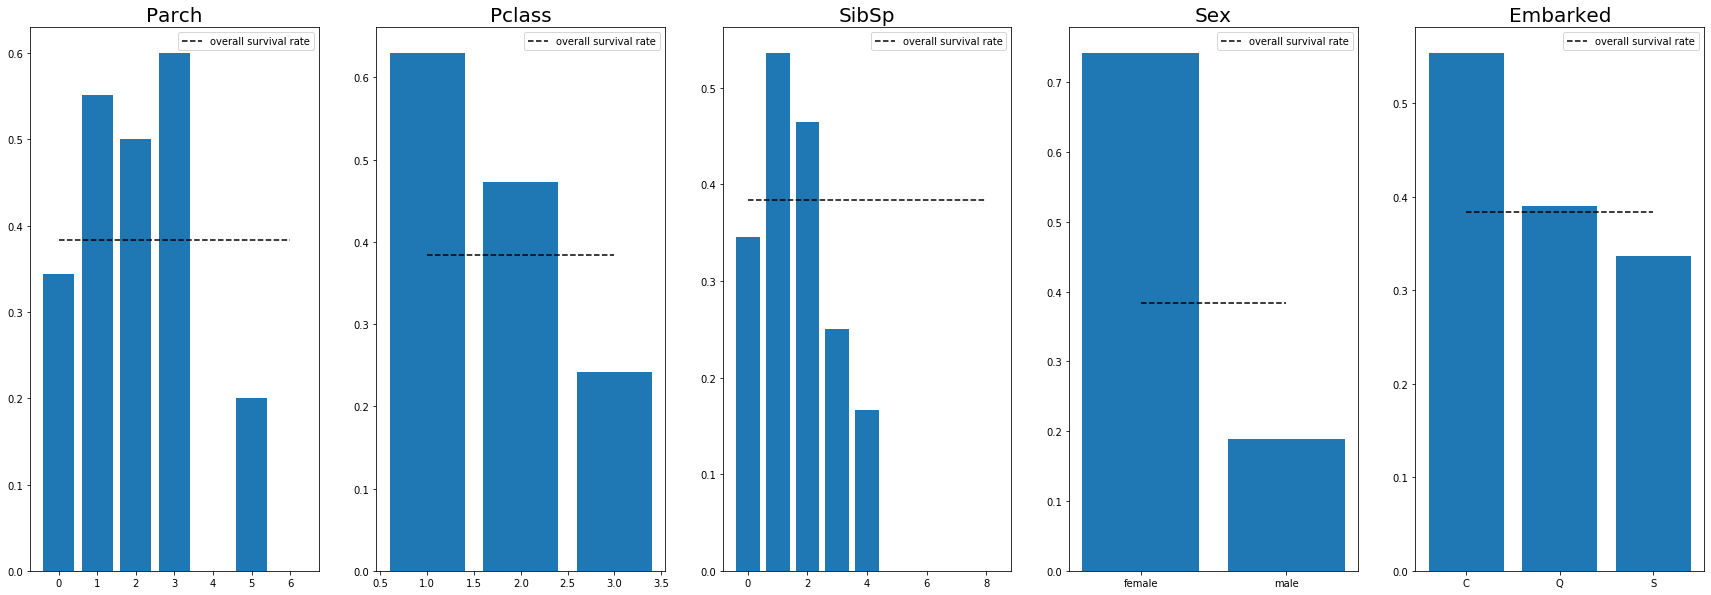

In [6]:
survival_rate = train.Survived.mean()

# Discrete variables
fig, axs = plt.subplots(1,len(f_discrete),figsize = (30,10))
for i,f in enumerate(f_discrete):
    df = train[[f,'Survived']].groupby(f).mean()
    axs[i].bar(df.index.values,df.Survived) 
    axs[i].plot(df.index.values,[survival_rate]*len(df.index.values),'k--',label = 'overall survival rate')
    axs[i].set_title(str(f), fontsize= 20)
    axs[i].legend()

>#### Comments
>- Sex and Pclass are important features: Female and higher class have higher survival rate
>- Higher survival rate with small but non zero SibSp, Parch numbers
>- Embarked at C has higher survival rate

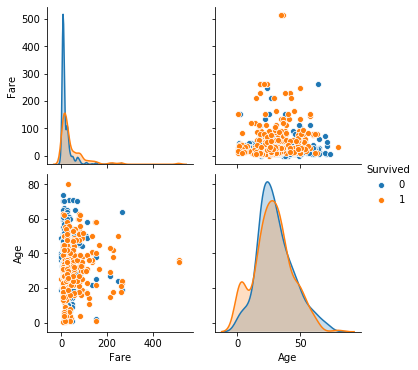

In [7]:
# continuous variables
f = f_continuous.copy()
f.append('Survived')
df = train[f].copy()
sns.pairplot(df, hue = 'Survived') 


> #### Comments
>- Age may be correlated to survival rate, with small age child having higher survival rate  
>- Fare may be correlated to survival rate, higher fare rate individuals having higher survival rate

In [8]:
features = f_discrete + f_continuous

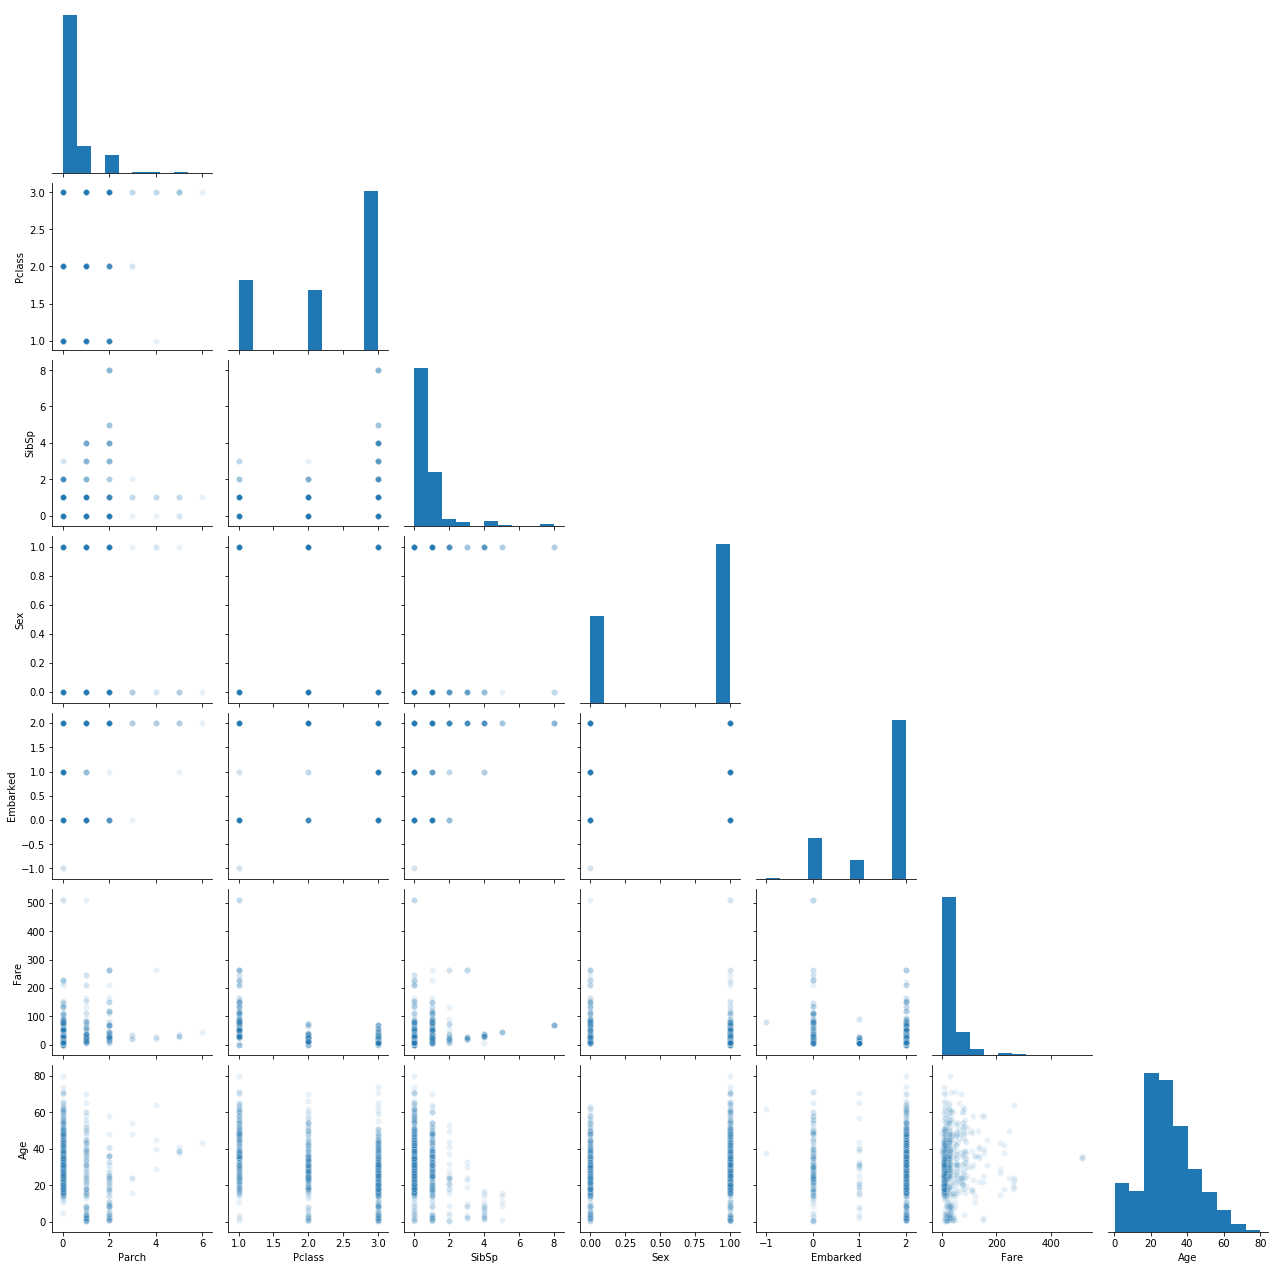

In [9]:
# Explore pariwise relationship of variables

df = train[features].copy()
f_object = train[features].select_dtypes(include = 'object').columns.values

for f in f_object:
    df[f] = df[f].astype('category')
    df[f] = df[f].cat.codes
    
sns.pairplot(df,corner = True,plot_kws={ 'alpha': 0.1})

>#### Comments
>- Age and Fare have long right tail
>- Fare and Pclass are correlated

### 3. feature engineering 
3.1. Fill up missing values  
3.2. Create new features  
3.3. Encode categorical variables

#### 3.1 Fill up missing values 
To fill up features: 
- Ages 
- Embarked 

In [10]:
age_guess = train['Age'].median()
embarked_guess = train['Embarked'].mode()

train['Age'].fillna(age_guess, inplace = True)
train['Embarked'].fillna(embarked_guess, inplace = True)


#### 3.2 Create new features
- To extract title from name  

In [11]:
train['Title'] = train['Name'].str.extract(pat = '.*\ (.*)\..*')

print(train['Title'].value_counts())

titles_regular = ['Mr','Miss','Mrs','Master']

train['Title'] = train['Title'].apply(lambda x: x if x in titles_regular else 'Rare')

features.append('Title')

Mr          517
Miss        182
Mrs         124
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Capt          1
L             1
Jonkheer      1
Lady          1
Sir           1
Ms            1
Countess      1
Don           1
Mme           1
Name: Title, dtype: int64


> #### Comments
> other methods to extract title from name:
>- train['Title'] = train['Name'].str.extract(pat = '([A-Za-z]+)\.')
>- train['Title'] = train['Name'].str.extract(pat = '.*\ (.*)\..*')
>- train['Title'] = train['Name']  
    train['Title'] = train['Title'].apply(lambda name: name[name.find(',')+2:name.find('.')])


#### 3.3 Adjust variables type
- To encode 
     - categorical variables Sex and Embarked
     - variable Title considered to be ordered (since there is rare and the list is in descending frequency order)
- Ordered variables (Pclass, Parch, SibSp) already in int format and continuous variables Age and Fare already in float format

In [12]:
train[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Parch     891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   SibSp     891 non-null    int64  
 3   Sex       891 non-null    object 
 4   Embarked  889 non-null    object 
 5   Fare      891 non-null    float64
 6   Age       891 non-null    float64
 7   Title     891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


In [13]:
train['Title'] = train['Title'].astype('category')
train['Title'] = train['Title'].cat.codes 
train = pd.get_dummies(train, columns = ['Sex', 'Embarked']) 


In [14]:
features = list(set(train.columns.values.tolist()) - set(f_excluded))
features.remove('Survived')
print(features)

['Parch', 'Pclass', 'Embarked_S', 'SibSp', 'Embarked_C', 'Fare', 'Sex_male', 'Age', 'Embarked_Q', 'Sex_female', 'Title']


In [15]:
# Sanity check
train[features].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Parch       891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Embarked_S  891 non-null    uint8  
 3   SibSp       891 non-null    int64  
 4   Embarked_C  891 non-null    uint8  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    uint8  
 7   Age         891 non-null    float64
 8   Embarked_Q  891 non-null    uint8  
 9   Sex_female  891 non-null    uint8  
 10  Title       891 non-null    int8   
dtypes: float64(2), int64(3), int8(1), uint8(5)
memory usage: 40.2 KB


### 4. modeling 
Compare 4 models:
- Logistic regression, can be served as a baseline model
- Support vector classifier
- Decision tree
- Random forest classifier


In [16]:
X = train[features]
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

analysis = pd.DataFrame([], columns = ['accuracy rate', 'time consumption'], index = ['Tree', 'Random forest', 'Logistic regression'])

#### 4.1 Logistic regression

In [17]:
logreg = LogisticRegression()

params = {'C': [0.1, 0.3, 1, 3, 10]}

logreg_cv = GridSearchCV(logreg, params, cv = 5, return_train_score = True)
logreg_cv.fit(X_train_scaled, y_train)

cv_results = logreg_cv.cv_results_
results = pd.DataFrame(index = cv_results['params'])
results['test'] = list(cv_results['mean_test_score'])
results['train'] = list(cv_results['mean_train_score'])
results['diff'] =  results['train'] - results['test']
print(results.sort_values(by = 'diff', ascending = True))
print('best pramater chosen by algorithm is:', logreg_cv.best_params_)

                test     train      diff
{'C': 0.1}  0.796219  0.806584  0.010365
{'C': 3}    0.788219  0.801367  0.013147
{'C': 10}   0.786619  0.800564  0.013945
{'C': 0.3}  0.791419  0.805381  0.013962
{'C': 1}    0.786606  0.803372  0.016766
best pramater chosen by algorithm is: {'C': 0.1}


In [18]:
logreg = logreg_cv.best_estimator_
coef = pd.Series((*logreg.coef_), index = features)
print(coef.sort_values())

Pclass       -0.741007
Sex_male     -0.603564
Age          -0.372114
SibSp        -0.360540
Embarked_S   -0.122506
Title        -0.090034
Parch        -0.076476
Embarked_Q    0.017113
Embarked_C    0.066723
Fare          0.092082
Sex_female    0.603564
dtype: float64


#### Comments
Logistic regression is highly interpretable. From the coefficients we understand that:  
>`Being a female, in a higher class, young and having less siblings increases the chance of survival`, which confirms our intuition/general information on the Titanic story

In [19]:
cv_score = cross_validate(logreg, X_train_scaled, y_train, cv = 5)
logreg_time = np.column_stack((cv_score['fit_time'],cv_score['score_time']))
time = sum(logreg_time.mean(axis = 0))
print('logistic regression:\nfit and score time is:', time)
logreg.fit(X_train_scaled, y_train)
score = logreg.score(X_test_scaled,y_test)
print('accuracy rate is:', score)

analysis.loc['Logistic regression','accuracy rate'] = score
analysis.loc['Logistic regression','time consumption'] = time 

logistic regression:
fit and score time is: 0.013278341293334961
accuracy rate is: 0.7947761194029851


#### 4.2 Support vector classifier

In [20]:
svc = SVC(random_state = 0)

params = {
    'C':[0.1, 0.3, 1, 3, 10],
    'kernel': ['linear', 'rbf']
}

svc_cv = GridSearchCV(svc, params, cv = 5, return_train_score = True )
svc_cv.fit(X_train_scaled, y_train)

cv_results = svc_cv.cv_results_
results = pd.DataFrame(index = cv_results['params'])
results['cv'] = cv_results['mean_test_score']
results['train'] = cv_results['mean_train_score']
results['diff'] = results['train'] - results['cv']
print(results.sort_values(by = 'diff', ascending = True))
print(svc_cv.best_params_)

                                      cv     train      diff
{'C': 0.3, 'kernel': 'linear'}  0.789794  0.789730 -0.000063
{'C': 0.1, 'kernel': 'linear'}  0.788181  0.788127 -0.000053
{'C': 1, 'kernel': 'linear'}    0.789794  0.790131  0.000338
{'C': 3, 'kernel': 'linear'}    0.789794  0.790131  0.000338
{'C': 10, 'kernel': 'linear'}   0.789794  0.790131  0.000338
{'C': 0.3, 'kernel': 'rbf'}     0.833110  0.841092  0.007982
{'C': 1, 'kernel': 'rbf'}       0.833071  0.849917  0.016846
{'C': 0.1, 'kernel': 'rbf'}     0.807458  0.825444  0.017986
{'C': 3, 'kernel': 'rbf'}       0.818581  0.861156  0.042575
{'C': 10, 'kernel': 'rbf'}      0.805729  0.876003  0.070274
{'C': 0.3, 'kernel': 'rbf'}


In [21]:
svc = svc_cv.best_estimator_

cv_score = cross_validate(svc, X_train_scaled, y_train, cv = 5)
svc_time = np.column_stack((cv_score['fit_time'],cv_score['score_time']))
time = sum(svc_time.mean(axis = 0))
print('SVC model:\nfit and score time is:',time)

svc.fit(X_train_scaled, y_train)
score = svc.score(X_test_scaled, y_test)
print('accuracy rate is:', score)

analysis.loc['SVC','accuracy rate'] = score
analysis.loc['SVC','time consumption'] = time


SVC model:
fit and score time is: 0.011670684814453124
accuracy rate is: 0.8283582089552238


#### 4.3 Decision tree classifier

In [22]:
tree = DecisionTreeClassifier(random_state = 0)

params = {'max_depth': [2,3,5]}

model_cv = GridSearchCV(tree, cv = 5, param_grid = params, return_train_score = True)
model_cv.fit(X_train,y_train)

cv_results = model_cv.cv_results_
results = pd.DataFrame(index = cv_results['params'])
results['cv'] = list(cv_results['mean_test_score'])
results['train'] = list(cv_results['mean_train_score'])
results['diff'] =  results['train'] - results['cv']
print(results.sort_values(by = 'diff', ascending = True))
print(model_cv.best_params_)

                        cv     train      diff
{'max_depth': 3}  0.820258  0.835873  0.015615
{'max_depth': 2}  0.762413  0.795345  0.032932
{'max_depth': 5}  0.812258  0.868376  0.056118
{'max_depth': 3}


In [23]:
tree = model_cv.best_estimator_
cv_score = cross_validate(tree, X_train, y_train, cv = 5, return_estimator = True)
tree_time = np.column_stack((cv_score['fit_time'],cv_score['score_time']))
print('tree model:\nfit and score time is:',sum(tree_time.mean(axis = 0)))

tree.fit(X_train, y_train)
print('accuracy rate is:',tree.score(X_test, y_test))

analysis.loc['Tree','accuracy rate'] = tree.score(X_test, y_test)
analysis.loc['Tree','time consumption'] = sum(tree_time.mean(axis = 0))


tree model:
fit and score time is: 0.005677604675292968
accuracy rate is: 0.8246268656716418


In [24]:
importances = pd.Series(tree.feature_importances_,index = features)
importances.sort_values(ascending  = False)

Sex_male      0.600868
Pclass        0.172492
SibSp         0.105447
Title         0.057193
Fare          0.051909
Age           0.012092
Sex_female    0.000000
Embarked_Q    0.000000
Embarked_C    0.000000
Embarked_S    0.000000
Parch         0.000000
dtype: float64

>#### Comments
>**Sex** and **Pclass** are the most important discrete features and **Fare** is the most important continuous feature for tree estimator

#### 4.4 Random forest classifier

In [ ]:
rf = RandomForestClassifier(random_state = 0)

params = {'max_depth': [2,3,5], 
          'n_estimators': [100, 200]}

rf_cv = GridSearchCV(rf, cv = 5, param_grid = params, return_train_score = True)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_)
cv_results = rf_cv.cv_results_
results = pd.DataFrame(index = cv_results['params'])
results['CV'] = list(cv_results['mean_test_score'])
results['train'] = list(cv_results['mean_train_score'])
results['diff'] =  results['train'] - results['CV']
print(results.sort_values(by = 'diff', ascending = True))

In [ ]:
rf = rf_cv.best_estimator_
cv_results = cross_validate(rf, X_train, y_train, cv = 5, return_estimator = True)

In [ ]:
rf_time = np.column_stack((cv_results['fit_time'],cv_results['score_time']))
time = sum(rf_time.mean(axis = 0))
print('random forest fit and score time is:', time)
rf_cv_score = cv_results['test_score']
print('accuracy score interval is: [', rf_cv_score.mean() - 2*rf_cv_score.std(),',', rf_cv_score.mean() + 2*rf_cv_score.std(),']')

In [ ]:
importances = []

for i,e in enumerate(cv_results['estimator']):
    importances.append(e.feature_importances_)
importances_df = pd.DataFrame(importances,columns = features)
importances_mean = importances_df.mean(axis = 0)
importances_mean.sort_values(ascending = False)

>#### Comments
>- Random forest may potentially increase the possibility of overfitting by randomly picking noise features. Here we will try selecting the features with the highest importance.   
>- To select most important features, we examine the features_importances_ by combining the same variable importances and looking at the ranking of discrete and continuous variables separating:  
>    - Discrete variables:
>        - `Sex is the most important variable` with total importance at 0.59
>        - Followed by `Title` (0.12) and `Pclass` (0.10)
>    - Continuous variables: Keep `Fare` variable
>- Comparing random forest's features importances vs. tree model, we see that 
>    - ranking of different features remains generally the same, showing the consistency between the 2 tree based models  
>    - random forest has a less concentrated importance distribution among features, explained by the bootstrap constitution method of random forest

In [ ]:
# feature selection
features_rf = ['Sex_female', 'Sex_male', 'Title','Pclass','Fare']
X_train_rf = X_train[features_rf]
X_test_rf = X_test[features_rf]

cv_results = cross_validate(rf, X_train_rf, y_train, cv = 5)
rf_time = np.column_stack((cv_results['fit_time'],cv_results['score_time']))
time = sum(rf_time.mean(axis = 0))
print('random forest fit and score time is:', time)

rf.fit(X_train_rf, y_train)
score = rf.score(X_test_rf, y_test)
print('accuracy rate is:', score)

analysis.loc['Random forest','accuracy rate'] = score
analysis.loc['Random forest','time consumption'] = time 

>#### Comments
>feature engineering leads to slightly faster training and scoring time, and the accuracy rate remains within the accuracy interval estimated with CV scores 

In [ ]:
# Comparison of Tree and Random Forest Model
y_pred_tree = tree.predict(X_test)
y_pred_rf = rf.predict(X_test_rf)
y_compare = pd.DataFrame(np.column_stack((y_test, y_pred_tree, y_pred_rf)),columns = ['y_test','Tree','RF'],index = X_test.index)
compare = pd.concat([X_test,y_compare], axis = 1)
compare.loc[compare['Tree'] != compare['RF']]

>#### Comments
>For most of the data, the Decision Tree model seems having the same predictions as the random forest model, explaining the fact that they have similar prediction accuracy


#### 5. Conclusion

In [ ]:
analysis

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (20,5))
axs[0].bar(analysis.index.values,analysis['accuracy rate'])
axs[0].set_title('Accuracy comparison')
axs[0].set_ylim([0.7,0.9])
axs[1].bar(analysis.index.values,analysis['time consumption'])
axs[1].set_title('Fitting and scoring time comparison')

#### Conclusion

- In terms of **accuracy score**: 
    - The 4 models have similar performance, with `tree based models and SVC having slightly better performance` around 0.82-0.83
- In terms of **time consumption**:  
    - `Decision tree model excels` due to the simplicity of the model (and also the problem). Logistic regression and SVC follow slightly behind, and random forest consumes the longest time

Overall, **decision tree model suits this Titanic dataset the best** among the 4 models investigated in terms of execution time and accuracy. In addition, tree model is easy to interpret by examining the most important features for the model. We can even draw the decision tree structure to understand the whole decision process (not included in this notebook).  

Random forest model has the highest test accuracy score, however it is time consuming as it builds a lot of tree models (in our case 100 trees). SVC model has a very good accuracy score and fast to fit and score. However, it is difficult to interpret. Logistic regression has a relatively good accuracy considering its small execution time and high interpretability, serving well as a baseline model for algorithm comparison.
